## Imports

In [2]:
import os
from pathlib import Path
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

try:
    import cupy as cp
    if cp.cuda.is_available():
        print("GPU is available")
        print("GPU:", cp.cuda.runtime.getDeviceProperties(0)["name"])
    else:
        print("CuPy installed but no GPU detected")
except Exception as e:
    print(f"GPU not available: {e}")
    print("Running on CPU only")

from IPython.display import HTML, display
import h5py
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

plt.rcParams["figure.figsize"] = (5, 4)
tempdir = tempfile.TemporaryDirectory()

GPU is available
GPU: b'NVIDIA GeForce GTX 1050 Ti'


c:\Users\Logan\OneDrive\Desktop\Electrodynamics_II\.pixi\envs\default\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## R sweep

### R1

In [3]:
BASE_PHYSICAL_PARAMS = {
    "length_units": "um",
    "xi": 0.1,
    "london_lambda": 2,
    "thickness": 0.1,
    "gamma": 1,
    "width": 0.5,
    "height": 0.5,
    "terminal_size": (0.05, 0.2),
}


def create_device(hole_radius: float) -> tdgl.Device:
    params = dict(BASE_PHYSICAL_PARAMS)
    params["hole_radius"] = float(hole_radius)
    layer = tdgl.Layer(
        coherence_length=params["xi"],
        london_lambda=params["london_lambda"],
        thickness=params["thickness"],
        gamma=params["gamma"],
    )
    film = tdgl.Polygon("film", points=box(params["width"], params["height"])).resample(401)
    hole = tdgl.Polygon("hole", points=circle(params["hole_radius"], center=(0, 0)))
    term_width, term_height = params["terminal_size"]
    source1 = (
        tdgl.Polygon("source1", points=box(term_width, term_height))
        .translate(-params["width"] / 2, 0)
        .buffer(0)
    )
    drain1 = (
        tdgl.Polygon("drain1", points=box(term_width, term_height))
        .translate(params["width"] / 2, 0)
        .buffer(0)
    )
    probe_points = [((-params["width"] * 0.25, 0.0), (params["width"] * 0.25, 0.0))]
    return tdgl.Device(
        "2currents",
        layer=layer,
        film=film,
        holes=[hole],
        terminals=[source1, drain1],
        length_units=params["length_units"],
        probe_points=probe_points,
    )


RADIUS_VALUES = np.asarray([0.02, 0.04, 0.06, 0.08, 0.10], dtype=float)
CURRENT_VALUES = np.round(np.linspace(0, 20, 80), 3)
H_FIELD_VALUE = 20.0  # mT

sweep_root = Path("../datasets/R_sweep_cache")
sweep_root.mkdir(exist_ok=True)

base_options = tdgl.SolverOptions(
    solve_time=150,
    output_file=os.path.join(tempdir.name, "R_sweep.h5"),
    field_units="mT",
    current_units="uA",
)

radius_voltage_traces = {}
radius_time_traces = {}
radius_steady_voltages = {}

for radius in RADIUS_VALUES:
    device = create_device(radius)
    device.make_mesh(max_edge_length=BASE_PHYSICAL_PARAMS["xi"] / 4, smooth=100)
    applied_vector_potential = tdgl.sources.constant.ConstantField(
        H_FIELD_VALUE,
        field_units=base_options.field_units,
        length_units=device.length_units,
    )
    radius_dir = sweep_root / f"R_{radius:05.2f}um"
    radius_dir.mkdir(exist_ok=True)

    rad_voltages = []
    rad_times = []
    rad_steady = []
    for cur_index, bias in enumerate(CURRENT_VALUES):
        save_path = radius_dir / f"bias_{cur_index:04d}.npz"
        if save_path.exists():
            cached = np.load(save_path)
            voltage_trace = cached["voltage"]
            time_trace = cached["time"]
        else:
            sweep_solution = tdgl.solve(
                device=device,
                options=base_options,
                applied_vector_potential=applied_vector_potential,
                terminal_currents=dict(source1=float(bias), drain1=-float(bias)),
            )
            voltage_trace = sweep_solution.dynamics.voltage()
            time_trace = sweep_solution.dynamics.time
            np.savez_compressed(
                save_path,
                radius_um=radius,
                current=float(bias),
                time=time_trace,
                voltage=voltage_trace,
            )
        rad_voltages.append(voltage_trace)
        rad_times.append(time_trace)
        tail_start = int(0.5 * len(voltage_trace))
        rad_steady.append(float(np.mean(voltage_trace[tail_start:])))

    radius_voltage_traces[radius] = rad_voltages
    radius_time_traces[radius] = rad_times
    radius_steady_voltages[radius] = rad_steady

print(
    f"Barrido completado/recuperado: {len(RADIUS_VALUES)} radios x {len(CURRENT_VALUES)} corrientes en {sweep_root}",
)

Constructing Voronoi polygons: 100%|██████████| 2212/2212 [00:01<00:00, 1416.79it/s]


Barrido completado/recuperado: 5 radios x 80 corrientes en ..\datasets\R_sweep_cache


## Voltaje vs tiempo por radio
Selecciona 10 corrientes equiespaciadas y muestra una figura independiente para cada radio.

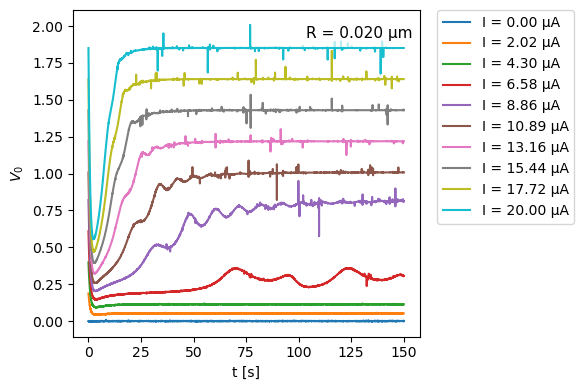

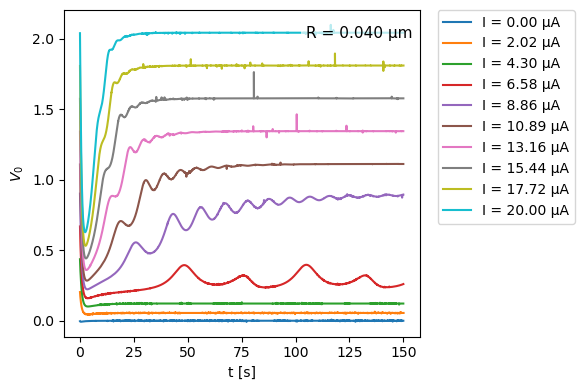

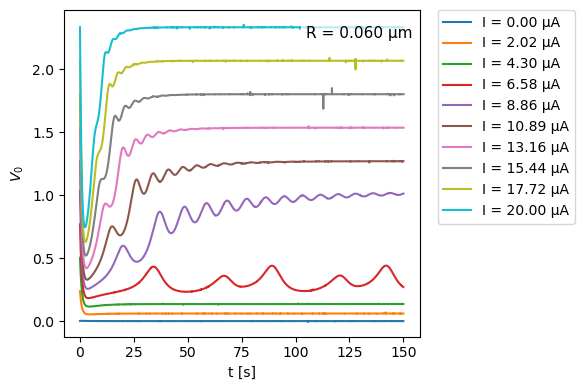

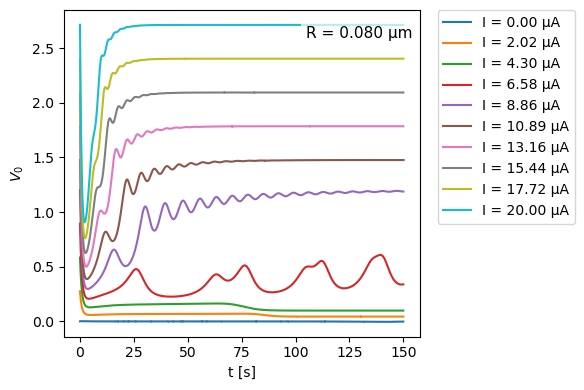

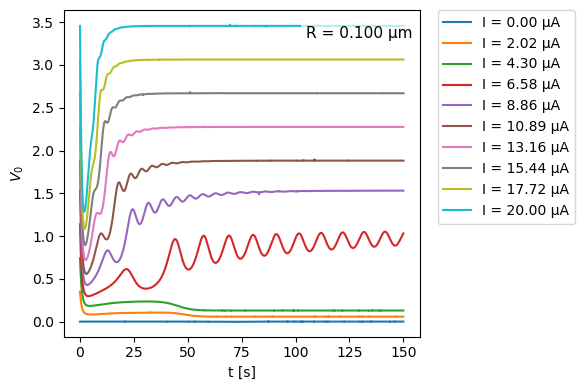

In [4]:
currents_per_plot = 10
sample_indices = np.linspace(0, len(CURRENT_VALUES) - 1, currents_per_plot, dtype=int)

for radius in RADIUS_VALUES:
    voltages = radius_voltage_traces.get(radius, [])
    times = radius_time_traces.get(radius, [])
    if not voltages or not times:
        print(f"Sin datos almacenados para R = {radius:.3f} μm")
        continue
    plt.figure(figsize=(6, 4))
    for idx in sample_indices:
        if idx >= len(voltages):
            continue
        plt.plot(times[idx], voltages[idx], label=f"I = {CURRENT_VALUES[idx]:.2f} μA")
    plt.xlabel("t [s]")
    plt.ylabel("$V_0$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.text(
        0.98,
        0.95,
        f"R = {radius:.3f} μm",
        transform=plt.gca().transAxes,
        ha="right",
        va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )
    plt.tight_layout()
plt.show()

## Curvas I-V por radio
Voltaje estacionario vs corriente para cada radio codificado en color.

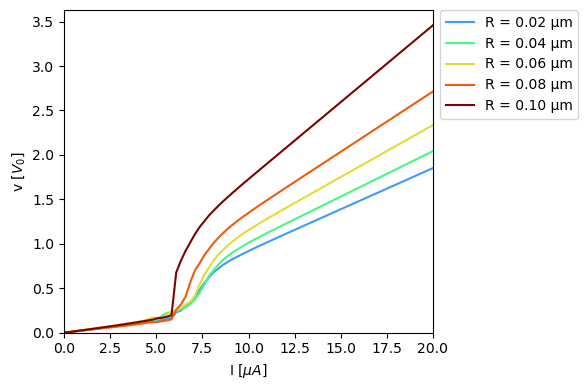

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
max_radius = np.max(RADIUS_VALUES) if len(RADIUS_VALUES) else 1.0
for radius in RADIUS_VALUES:
    volt_curve = radius_steady_voltages.get(radius)
    if not volt_curve:
        continue
    ax.plot(
        CURRENT_VALUES,
        volt_curve,
        label=f"R = {radius:.2f} μm",
        c=cm.turbo(radius / max_radius),
    )
sm = plt.cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=np.min(RADIUS_VALUES), vmax=max_radius))
sm.set_array([])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
ax.set_xlabel("I [$\mu A$]")
ax.set_ylabel("v [$V_0$]")
ax.set_xlim(0, 20)
ax.set_ylim(bottom=0)
# ax.set_title("Curvas I-V por radio del defecto")
plt.tight_layout()

## Resistencia diferencial vs corriente
Gradiente dV/dI para cada radio.

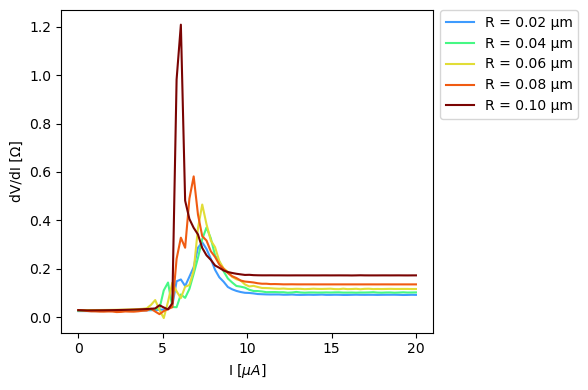

In [7]:
resistance_curves = []  # almacenamos por si se necesita después
plt.figure(figsize=(6, 4))
for radius in RADIUS_VALUES:
    volt_curve = radius_steady_voltages.get(radius)
    if not volt_curve:
        continue
    dv_di = np.gradient(np.asarray(volt_curve, dtype=float), CURRENT_VALUES)
    resistance_curves.append((radius, dv_di))
    plt.plot(
        CURRENT_VALUES,
        dv_di,
        label=f"R = {radius:.2f} μm",
        c=cm.turbo(radius / np.max(RADIUS_VALUES)),
    )
plt.xlabel("I [$\mu A$]")
plt.ylabel("dV/dI [Ω]")
#plt.title("Resistencia diferencial vs corriente (barrido en radio)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

## Corriente crítica vs radio
Estimación con umbral de voltaje y ajuste cuadrático.

R = 0.02 μm -> J1 ≈  0.79 μA
R = 0.04 μm -> J1 ≈  0.74 μA
R = 0.06 μm -> J1 ≈  0.68 μA
R = 0.08 μm -> J1 ≈  0.79 μA
R = 0.10 μm -> J1 ≈  0.71 μA
J1(R) ≈ 18.1158 R^2 + -2.7024 R + 0.8242


C:\Users\Logan\AppData\Local\Temp\ipykernel_15668\4020339699.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


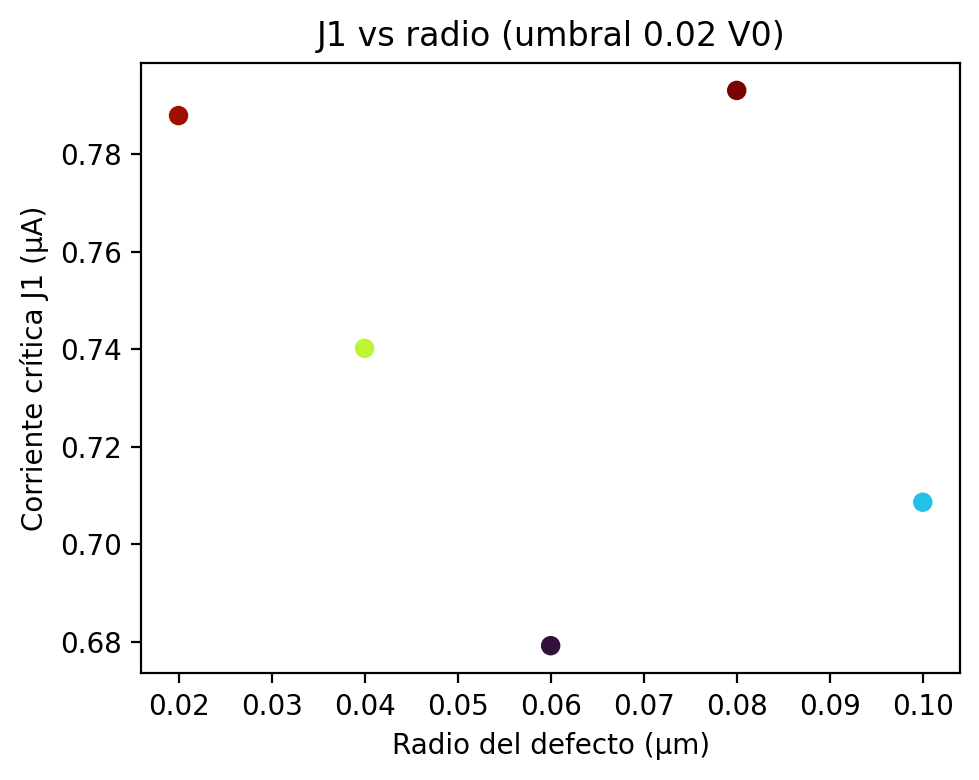

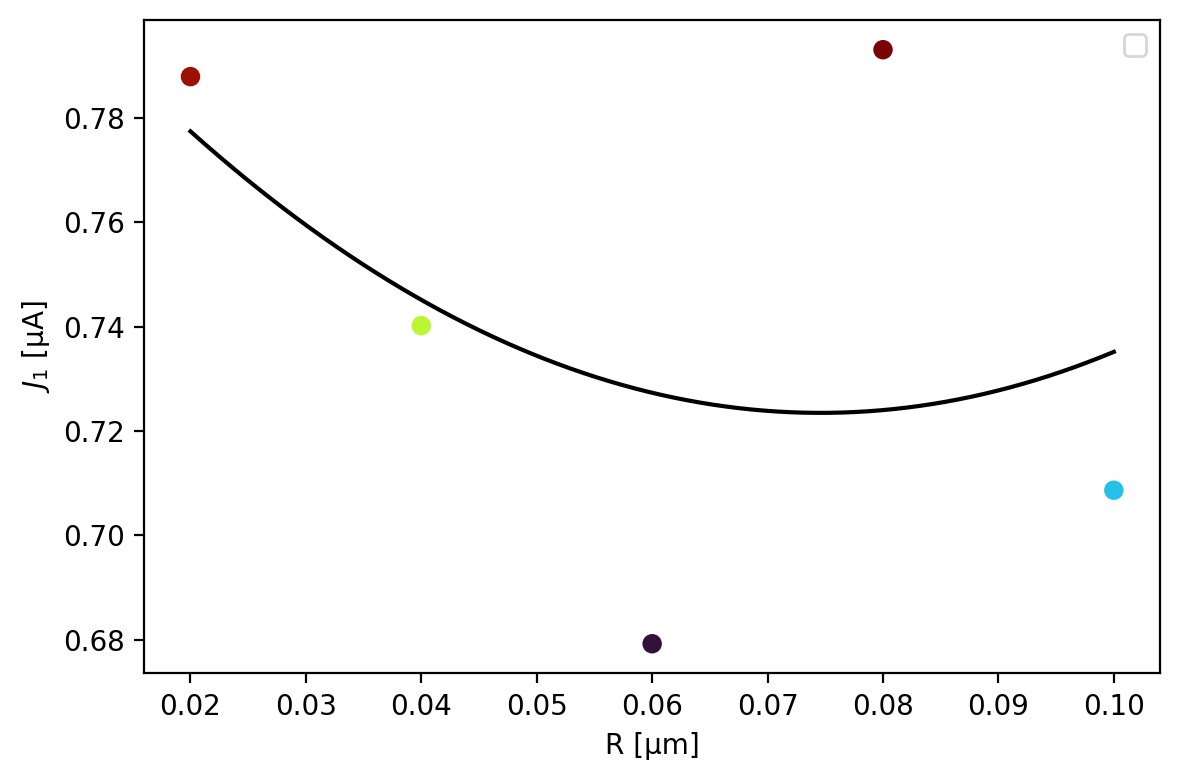

In [8]:
def estimate_j1(currents, voltages, threshold=0.02):
    currents = np.asarray(currents, dtype=float)
    voltages = np.asarray(voltages, dtype=float)
    valid = np.isfinite(currents) & np.isfinite(voltages)
    currents = currents[valid]
    voltages = voltages[valid]
    if len(currents) < 2:
        return np.nan
    above = np.where(voltages >= threshold)[0]
    if len(above) == 0:
        return np.nan
    idx = above[0]
    if idx == 0:
        return currents[0]
    i0, i1 = currents[idx - 1], currents[idx]
    v0, v1 = voltages[idx - 1], voltages[idx]
    if v1 == v0:
        return i1
    return float(np.interp(threshold, [v0, v1], [i0, i1]))

threshold_voltage = 0.02
critical_currents = []
for radius in RADIUS_VALUES:
    volt_curve = radius_steady_voltages.get(radius)
    if not volt_curve:
        critical_currents.append(np.nan)
    else:
        critical_currents.append(estimate_j1(CURRENT_VALUES, volt_curve, threshold_voltage))
critical_currents = np.asarray(critical_currents, dtype=float)

plt.figure(figsize=(5, 4), dpi=200)
plt.scatter(RADIUS_VALUES, critical_currents, c=critical_currents, cmap=cm.turbo)
plt.xlabel("Radio del defecto (μm)")
plt.ylabel("Corriente crítica J1 (μA)")
plt.title(f"J1 vs radio (umbral {threshold_voltage:.2f} V0)")
plt.tight_layout()

for radius, j1 in zip(RADIUS_VALUES, critical_currents):
    print(f"R = {radius:4.2f} μm -> J1 ≈ {j1:5.2f} μA")

valid_mask = np.isfinite(critical_currents)
if np.count_nonzero(valid_mask) >= 3:
    r_valid = np.asarray(RADIUS_VALUES)[valid_mask]
    j_valid = critical_currents[valid_mask]
    quad_coeffs = np.polyfit(r_valid, j_valid, 2)
    quad_poly = np.poly1d(quad_coeffs)
    radius_dense = np.linspace(r_valid.min(), r_valid.max(), 500)
    j_fit = quad_poly(radius_dense)
    plt.figure(figsize=(6, 4), dpi=200)
    plt.scatter(r_valid, j_valid, c=j_valid, cmap=cm.turbo )
    plt.plot(radius_dense, j_fit, color="black", linewidth=1.5)
    plt.xlabel("R [μm]")
    plt.ylabel("$J_1$ [μA]")
    #plt.title("J1(R) con ajuste cuadrático")
    plt.legend()
    plt.tight_layout()
    a, b, c = quad_coeffs
    print(f"J1(R) ≈ {a:.4f} R^2 + {b:.4f} R + {c:.4f}")
else:
    print("No hay suficientes puntos válidos para ajustar J1(R).")

## Snapshots de |Ψ|² y Δφ (I = 10 μA)
Genera o reutiliza soluciones completas para cada radio con corriente fija de 10 μA y grafica la densidad y la fase en el dispositivo, junto con Δφ entre las máscaras izquierda/derecha.

Guardando snapshot para R = 0.10 μm en R_snapshots_full\I_10.00uA


Constructing Voronoi polygons: 100%|██████████| 2212/2212 [00:01<00:00, 1382.97it/s]


✔ Snapshot cacheado: R_00.10um.h5


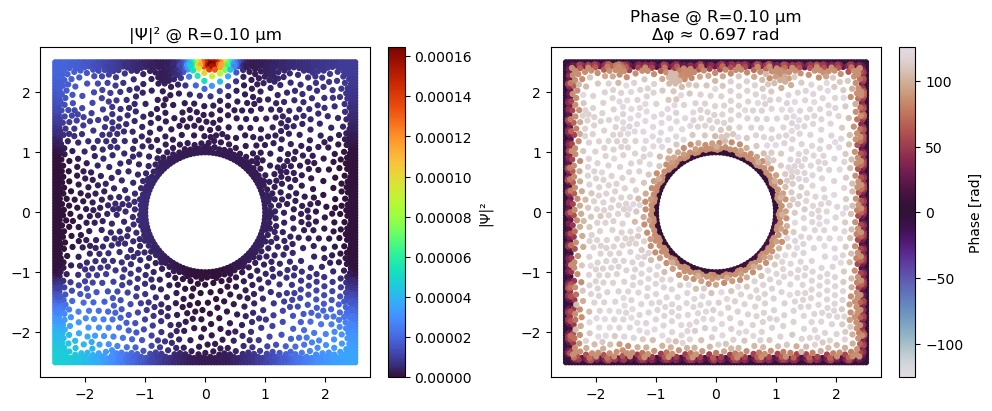

,radius_um,current_uA,delta_phi,file
0,0.1,10.0,0.697403,R_snapshots_full\I_10.00uA\R_00.10um.h5


In [9]:
snapshot_current = 10.0  # μA
snapshot_radius = 0.10  # μm
snapshot_root = Path("R_snapshots_full") / f"I_{snapshot_current:05.2f}uA"
snapshot_root.mkdir(parents=True, exist_ok=True)
print(f"Guardando snapshot para R = {snapshot_radius:.2f} μm en {snapshot_root}")

if snapshot_radius not in RADIUS_VALUES:
    raise ValueError(
        f"El radio objetivo {snapshot_radius} μm no está en RADIUS_VALUES: {RADIUS_VALUES}"
    )


def extract_mesh_coords(device_obj):
    mesh = device_obj.mesh
    for attr in ("points", "sites", "vertices", "coordinates"):
        if hasattr(mesh, attr):
            data = getattr(mesh, attr)
            data = data() if callable(data) else data
            arr = np.asarray(data)
            if arr.ndim >= 2 and arr.shape[1] >= 2:
                return arr
    raise AttributeError("No se pudieron obtener las coordenadas del mesh.")


def build_masks(device_obj, radius, left_x=-0.05, right_x=0.05):
    coords = extract_mesh_coords(device_obj)
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    hole_center = np.array([0.0, 0.0])
    left_mask = x_coords < left_x
    right_mask = x_coords > right_x
    distance_to_hole = np.hypot(x_coords - hole_center[0], y_coords - hole_center[1])
    in_hole_mask = distance_to_hole <= radius
    if not np.any(left_mask) or not np.any(right_mask):
        raise RuntimeError("Alguna máscara lateral quedó vacía; ajusta left_x/right_x.")
    if np.any(in_hole_mask & (left_mask | right_mask)):
        raise RuntimeError("Una máscara intersecta el hueco; ajusta left_x/right_x.")
    return dict(
        x=x_coords,
        y=y_coords,
        left_mask=left_mask,
        right_mask=right_mask,
    )


def load_or_solve_snapshot(device_obj, radius):
    snapshot_file = snapshot_root / f"R_{radius:05.2f}um.h5"
    if snapshot_file.exists():
        print(f"✔ Snapshot cacheado: {snapshot_file.name}")
        return tdgl.Solution.from_hdf5(snapshot_file), snapshot_file
    applied_field = tdgl.sources.constant.ConstantField(
        H_FIELD_VALUE,
        field_units=base_options.field_units,
        length_units=device_obj.length_units,
    )
    snapshot_options = tdgl.SolverOptions(
        solve_time=200,
        output_file=str(snapshot_file),
        field_units="mT",
        current_units="uA",
    )
    solution = tdgl.solve(
        device=device_obj,
        options=snapshot_options,
        applied_vector_potential=applied_field,
        terminal_currents=dict(source1=snapshot_current, drain1=-snapshot_current),
    )
    return solution, snapshot_file


device_r = create_device(snapshot_radius)
device_r.make_mesh(max_edge_length=BASE_PHYSICAL_PARAMS["xi"] / 4, smooth=100)
mask_data = build_masks(device_r, snapshot_radius)
solution, snapshot_file = load_or_solve_snapshot(device_r, snapshot_radius)

if solution.tdgl_data is None or solution.tdgl_data.psi is None:
    raise RuntimeError(f"La solución para R={snapshot_radius:.2f} μm no contiene psi.")

psi_vals = np.asarray(solution.tdgl_data.psi)
density_vals = np.abs(psi_vals) ** 2
phase_vals = np.angle(psi_vals)
left_phase = np.angle(np.mean(psi_vals[mask_data["left_mask"]]))
right_phase = np.angle(np.mean(psi_vals[mask_data["right_mask"]]))
delta_phi = np.unwrap([left_phase, right_phase])[1] - np.unwrap([left_phase, right_phase])[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
sc0 = axes[0].scatter(mask_data["x"], mask_data["y"], c=density_vals, s=12, cmap="turbo")
axes[0].set_title(f"|Ψ|² @ R={snapshot_radius:.2f} μm")
axes[0].set_aspect("equal")
plt.colorbar(sc0, ax=axes[0], label="|Ψ|²")

wrapped_phase = np.unwrap(phase_vals)
sc1 = axes[1].scatter(
    mask_data["x"],
    mask_data["y"],
    c=wrapped_phase,
    s=12,
    cmap="twilight",
    norm=mcolors.CenteredNorm(),
)
axes[1].set_title(f"Phase @ R={snapshot_radius:.2f} μm\nΔφ ≈ {delta_phi:.3f} rad")
axes[1].set_aspect("equal")
plt.colorbar(sc1, ax=axes[1], label="Phase [rad]")
plt.show()

snapshot_records = [
    {
        "radius_um": float(snapshot_radius),
        "current_uA": float(snapshot_current),
        "delta_phi": float(delta_phi),
        "file": str(snapshot_file),
    }
]
snapshot_df = pd.DataFrame(snapshot_records)
display(snapshot_df)